In [234]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch import nn
import torch.nn.functional as F
import os 
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm_notebook



transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

path = os.getcwd()
train_data = torchvision.datasets.MNIST(path, download = True, train = True, transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]))
test_data = torchvision.datasets.MNIST(path, download = True, train = False, transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]))
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

train_loader = DataLoader(dataset=train_data, batch_size = 16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size = 16, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size = 16, shuffle=True)

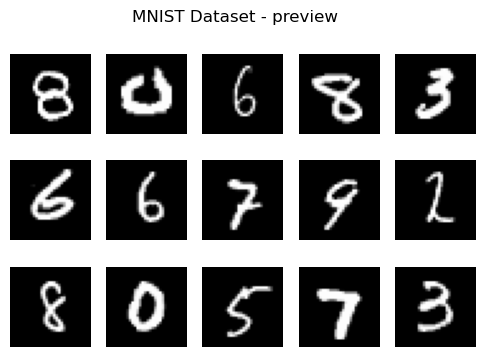

In [235]:
fig = plt.figure(dpi = 100)
for index in range(1, 3 * 5 + 1):
    plt.subplot(3, 5, index)
    plt.axis('off')
    plt.imshow(next(iter(train_loader))[0][index].reshape(32,32), cmap='gray')
fig.suptitle('MNIST Dataset - preview');

In [237]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.c1 = nn.Conv2d(in_channels = 1,out_channels = 6,kernel_size = 5, stride = 1, padding = 0)
        self.c2 = nn.Conv2d(in_channels = 6,out_channels = 16,kernel_size = 5, stride = 1, padding = 0)
        self.fc1 = nn.Linear(in_features = 16*5*5, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)
        self.fc3 = nn.Linear(in_features = 84, out_features = 10)
    
    def forward(self,x):
        x = F.avg_pool2d(torch.tanh(self.c1(x)), kernel_size = 2, stride = 2, padding = 0)
        x = F.avg_pool2d(torch.tanh(self.c2(x)), kernel_size = 2, stride = 2, padding = 0)
        x = torch.flatten(x,1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        #x = F.log_softmax(x, dim = 1)
        #x = torch.argmax(x, dim = 1)
         
        return x 
        
leNet = LeNet()
x = leNet(next(iter(train_loader))[0])
l = nn.CrossEntropyLoss()
l(x,next(iter(train_loader))[1])

tensor(2.3151, grad_fn=<NllLossBackward>)

In [253]:
class network:
    def __init__(self,dataset, val_loader, model, learning_rate = 1e-1):
        self.dataset = dataset
        self.val_loader = val_loader
        self.model = model 
        self.lr = learning_rate
        self.loss_function = nn.CrossEntropyLoss()
        self.opt = torch.optim.SGD(self.model.parameters(), lr = self.lr)
        self.train_loss = []
        self.val_loss = []
        
    
    def validation(self):
        val_loss = 0
        
        self.model.eval()
        with torch.no_grad():
            for x,y in val_loader:
                outputs = self.model(x)
                loss = self.loss_function(outputs,y)
                val_loss += loss.item()
                
        return val_loss / len(val_loader)
        
    def train(self, epochs):
        self.model.train()
        for epoch in tqdm_notebook(range(epochs), desc = 'Epoch'):
            batch_loss = 0
            for inputs, targets in self.dataset:
                self.opt.zero_grad()
                
                outputs = self.model(inputs)
                
                loss = self.loss_function(outputs, targets)
                loss.backward()
                self.opt.step()
                batch_loss += loss.item()
            self.train_loss.append(batch_loss / len(self.dataset))
            self.val_loss.append(self.validation())
    
    def plot(self, save = False):
        x = [i for i in range(len(self.train_loss))]
        plt.figure(dpi=120)
        plt.grid()
        plt.plot(x, self.train_loss, color = 'b', label = 'Training')
        plt.plot(x, self.val_loss, color = 'y', label = 'Validation')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc = "upper right")
        if save:
            plt.savefig(path + "/figures/Loss_figure.png")

        
    def accuracy(self, test_loader):
        acc = 0
        for x, y in test_loader:
            output = torch.argmax(F.log_softmax(self.model(x)), dim = 1)
            acc += sum([1 for i in range(len(y)) if output[i] ==  y[i]]) / len(y)

        print("Accuracy : {}".format(acc/len(test_loader)))
                        


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-253-16434f928a7a>:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = torch.argmax(F.log_softmax(self.model(x)), dim = 1)


Accuracy : 0.9878


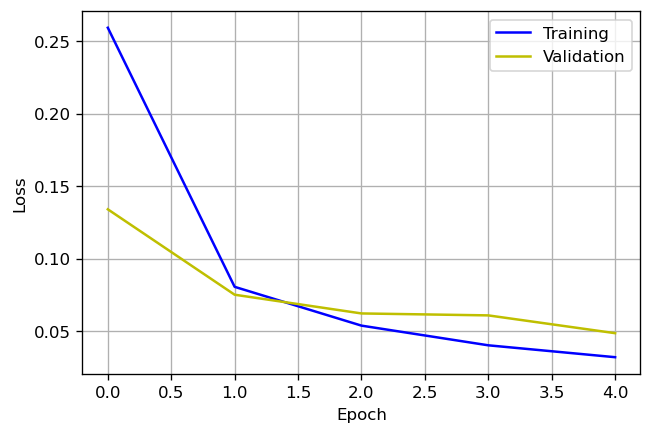

In [254]:
n = network(train_loader, val_loader, LeNet())
n.train(5)
n.plot()
n.accuracy(test_loader)